In [1]:
# prerequisite: down data files from kaggle
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

# References
# 1. longformer: https://github.com/allenai/longformer
# 2. longformer multilabel: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/

In [9]:
import torch
import pandas as pd
import numpy as np
from torch.nn import BCEWithLogitsLoss
from transformers import LongformerTokenizerFast, \
LongformerModel, LongformerConfig, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers.models.longformer.modeling_longformer import LongformerPreTrainedModel, LongformerClassificationHead
from torch.utils.data import Dataset, DataLoader
import random

## Load dataset 

In [6]:
# read the dataframe
insults = pd.read_csv('/media/hdddisk/jigsaw-toxic-comment/train.csv')
insults['labels'] = insults[insults.columns[2:]].values.tolist()
insults = insults[['id','comment_text', 'labels']].reset_index(drop=True)

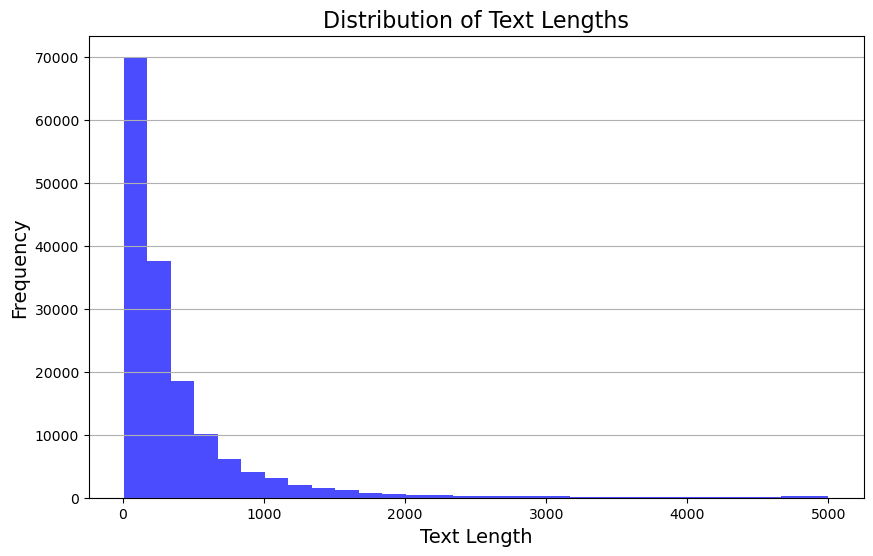

In [7]:
import matplotlib.pyplot as plt

text_list = insults["comment_text"].to_list()

# Calculate the length of each text item
text_lengths = [len(text) for text in text_list]

# Create the histogram of text lengths
plt.figure(figsize=(10, 6))

plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)

# Adding labels and title
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show plot
plt.grid(axis='y')
plt.show()

In [8]:
train_size = 0.001
train_dataset=insults.sample(frac=train_size,random_state=200)
test_dataset=insults.drop(train_dataset.index).sample(frac=train_size,random_state=200).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
print(len(train_dataset), len(test_dataset))
train_dataset

160 159


,id,comment_text,labels
0,6725d5a6391e5c77,Goal scored for Portugal \n\nThis could be mil...,"[0, 0, 0, 0, 0, 0]"
1,28ea0d2c61db3137,My mistake someone was vandalizing the page so...,"[0, 0, 0, 0, 0, 0]"
2,4de3d6b966b58ec7,Test card F music \nCeefax music isn't the sam...,"[0, 0, 0, 0, 0, 0]"
3,af602c4c5f1b09bc,""":Meh, I guess I can live with either outcome,...","[0, 0, 0, 0, 0, 0]"
4,9e412a7965873237,"UV is my error, above. I'm told by Kimberly Ja...","[0, 0, 0, 0, 0, 0]"
...,...,...,...
155,98a62f98dacc4553,Please use the articles discussion page.,"[0, 0, 0, 0, 0, 0]"
156,af256c8248ec2d55,I can't make a modification to the infobox of ...,"[0, 0, 0, 0, 0, 0]"
157,edc4512a1fb1bee5,"Dont say that was a bad deletion,this article ...","[0, 0, 0, 0, 0, 0]"
158,02769bc92e9bd063,"""\n\n """"no you're wrong, it's perfect acceptab...","[0, 0, 0, 0, 0, 0]"


## Train

In [6]:
# instantiate a Longformer for multilabel classification class
class LongformerForMultiLabelSequenceClassification(LongformerPreTrainedModel):
    """
    We instantiate a class of LongFormer adapted for a multilabel classification task. 
    This instance takes the pooled output of the LongFormer based model and passes it through a classification head. We replace the traditional Cross Entropy loss with a BCE loss that generate probabilities for all the labels that we feed into the model.
    """

    def __init__(self, config):
        super(LongformerForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.longformer = LongformerModel(config)
        self.classifier = LongformerClassificationHead(config)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None, 
                token_type_ids=None, position_ids=None, inputs_embeds=None, 
                labels=None):
        
        # create global attention on sequence, and a global attention token on the `s` token
        # the equivalent of the CLS token on BERT models. This is taken care of by HuggingFace
        # on the LongformerForSequenceClassification class
        if global_attention_mask is None:
            global_attention_mask = torch.zeros_like(input_ids)
            global_attention_mask[:, 0] = 1
        
        # pass arguments to longformer model
        outputs = self.longformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            global_attention_mask = global_attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids
        )
        
        # if specified the model can return a dict where each key corresponds to the output of a
        # LongformerPooler output class. In this case we take the last hidden state of the sequence
        # which will have the shape (batch_size, sequence_length, hidden_size). 
        sequence_output = outputs['last_hidden_state']
        
        # pass the hidden states through the classifier to obtain thee logits
        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            labels = labels.float()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.view(-1, self.num_labels))
            outputs = (loss,) + outputs
        
        
        return outputs

In [7]:
# instantiate a class that will handle the data
class Data_Processing(object):
    def __init__(self, tokenizer, id_column, text_column, label_column):
        
        # define the text column from the dataframe
        self.text_column = text_column.tolist()
    
        # define the label column and transform it to list
        self.label_column = label_column
        
        # define the id column and transform it to list
        self.id_column = id_column.tolist()
        
    
# iter method to get each element at the time and tokenize it using bert        
    def __getitem__(self, index):
        comment_text = str(self.text_column[index])
        comment_text = " ".join(comment_text.split())
        # encode the sequence and add padding
        inputs = tokenizer.encode_plus(comment_text,
                                       add_special_tokens = True,
                                       max_length= 128,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       truncation = True,
                                       return_tensors='pt')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        labels_ = torch.tensor(self.label_column[index], dtype=torch.float)
        id_ = self.id_column[index]
        return {'input_ids':input_ids[0], 'attention_mask':attention_mask[0], 
                'labels':labels_, 'id_':id_}
  
    def __len__(self):
        return len(self.text_column) 

batch_size = 2
# create a class to process the training and test data
tokenizer = AutoTokenizer.from_pretrained(
    'allenai/longformer-base-4096', 
    padding = 'max_length',
    truncation=True, 
    max_length = 3048
)
training_data = Data_Processing(
    tokenizer, 
    train_dataset['id'], 
    train_dataset['comment_text'], 
    train_dataset['labels']
)

test_data =  Data_Processing(
    tokenizer, 
    test_dataset['id'], 
    test_dataset['comment_text'], 
    test_dataset['labels']
)

# use the dataloaders class to load the data
dataloaders_dict = {
    'train': DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train':len(training_data),
    'val':len(test_data)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = LongformerForMultiLabelSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    gradient_checkpointing=False,
    attention_window = 512,
    num_labels = 6,
    return_dict=True
)

Some weights of LongformerForMultiLabelSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
    
def multi_label_metrics(predictions, labels):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_true = labels
    y_pred[np.where(probs >= 0.5)] = 1
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # define dictionary of metrics to return
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

# Use the aux EvalPrediction class to obtain prediction labels
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

# define the training arguments
training_args = TrainingArguments(
    output_dir = '/media/hdddisk/bert-classify-multi-label/results',
    num_train_epochs=5,                # Number of training epochs
    per_device_train_batch_size=1,     # Batch size for training
    per_device_eval_batch_size=1,      # Batch size for evaluation
    eval_strategy="steps",             # Evaluate every epoch = "epoch"
    eval_steps=100,                    # Number of steps between evaluations
    save_strategy="steps",             # Save model every epoch
    save_steps=100,
    load_best_model_at_end=True,
    # warmup_steps=100,                   # Number of warmup steps for learning rate scheduler
    learning_rate = 2e-5,
    weight_decay=0.01,
    logging_steps = 20,
    logging_dir='/media/hdddisk/bert-classify-multi-label/logs',
    run_name = 'longformer_multilabel_paper_trainer_3048_2e5',
    report_to="mlflow",                # Enable logging to MLflow
)
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_data,
    eval_dataset=test_data,
    compute_metrics = compute_metrics,
    #data_collator = Data_Processing(),

)

In [12]:
import mlflow
mlflow.set_tracking_uri("https://mlflow.yellowday.day")
mlflow.set_experiment("bert-classify-multi-label-jigsaw-toxic-comment")

<Experiment: artifact_location='mlflow-artifacts:/5', creation_time=1745557944529, experiment_id='5', last_update_time=1745557944529, lifecycle_stage='active', name='bert-classify-multi-label-jigsaw-toxic-comment', tags={}>

In [ ]:
with mlflow.start_run(run_name='longformer-multilabel-small-v2') as run:
    trainer.train()